In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import numpy as np
import multiprocessing as mp
import h5py
from typing import List
import random
import re

### Read read info

In [2]:
sustseqs_readinfo_df =pd.read_csv('./sustseqs_readinfo.tsv', sep='\t')

In [3]:
# filted barcode
filted_list = [9, 18, 19, 35, 55, 69, 99, 130, 151, 180, 247, 291, 306, 343, 375, 394]

def compute_sustag_name(barcode_name, filted_list):
    offset = sum(barcode_name > filt for filt in filted_list)
    return barcode_name - offset

sustseqs_readinfo_df['Sustag_name'] = sustseqs_readinfo_df['Barcode_name'].apply(compute_sustag_name, filted_list=filted_list)
sustseqs_readinfo_df

,read_id,channel,start_time,duration,Query_sequence_length,Query_start,Query_end,Relative_strand,Target_sequence_name,Target_sequence_length,Target_start_on_original_strand,Target_end_on_original_strand,Number_of_residue_matches,Alignment_block_length,Mapping_quality,Barcode_name,Sustag_name
0,8c1a74e7-fbf9-499c-b488-c3e63ac5fcc7,419,44.82025,0.77075,244,33,244,-,index254_0,243.0,29.0,243.0,211.0,214.0,60.0,210,200
1,da74b4db-883f-49f5-99a9-8a70d6293e5d,418,44.37250,0.74775,294,32,271,+,index398_0,243.0,0.0,243.0,238.0,243.0,60.0,358,344
2,5e3a0462-99d2-4481-b73b-c44c2af2cbc8,418,43.27300,0.77875,294,30,271,+,index175_0,243.0,0.0,243.0,238.0,244.0,60.0,128,121
3,480abeb3-0018-4049-9335-c635efabde69,417,44.91300,0.84775,340,35,195,-,index45_0,243.0,81.0,241.0,155.0,163.0,60.0,50,46
4,a3d2b794-e8f4-4ef0-af32-e5e118daa298,417,44.04350,0.59525,300,34,203,-,index185_0,243.0,72.0,243.0,164.0,173.0,60.0,139,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050277,89f41739-fcfd-40ec-aecc-d440299b3a14,5,57543.21650,0.66625,282,24,263,+,index0_0,243.0,3.0,243.0,227.0,248.0,60.0,1,1
12050278,244f5e2c-0679-464c-be43-c1bd11c23ac5,1,57552.50000,0.70225,0,0,0,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0,0
12050279,586c6ade-6aec-4bca-a203-408250216508,1,57544.74600,0.77850,0,0,0,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0,0
12050280,9ac5a795-9dad-4a81-a3d9-c43d7616b7f9,1,57544.24650,0.46600,0,0,0,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [4]:
import sys
sys.path.append('/home/lijy/workspace/')
from sustag.model.model_selec_CNNLSTM import CNN_LSTM, SelectiveNet
from sustag.utils.load_data import torch_data_loader_pickle_test
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader
import pickle

### build model

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# model_path = f"/home/lijy/workspace/sustag/training/checkpoints/finetuning_rate/e100/ORCovL_sustag384_1d1500_ckpt_e60_b1024_ft200k_c95_basec95_finetuning.pth"
model_path = "/home/lijy/workspace/sustag/training/checkpoints/finetuning_rate/e80/ORCovL_sustag384_1d1500_ckpt_e60_b1024_ft200k_c95_basec95_ft.pth"

num_class = 385
batch_size = 1024
dropout_rate=0.30
hidden_dim=128


features = CNN_LSTM(num_class, dropout_rate, hidden_dim).to(device)
model = SelectiveNet(features, 37 * hidden_dim, num_class, dropout_rate=dropout_rate).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

### simulation readuntil

#### 将sustseqs_readinfo_df 转换为字典并保存

In [ ]:
print('converting to dict...')
sustseqs_readinfo_dict = sustseqs_readinfo_df.set_index('read_id').to_dict('index')

with open('./sustseqs_readinfo_dict_sustag.P', 'wb') as f:
    pickle.dump(sustseqs_readinfo_dict, f)
print('done')

#### 读取字典 并 pred

In [6]:
with open('./sustseqs_readinfo_dict_sustag.P', 'rb') as f:
    sustseqs_readinfo_dict = pickle.load(f)

In [7]:
import h5py
import datetime

input_fast5_paths =  r'/data/biolab-nvme-pool1/lijy/seq_data/sustechseqs_230608/no_sample/20230608_1759_MN26597_FAS92658_95f4ad6b/fast5/'
filelist = os.listdir(input_fast5_paths)
file_raw_list = list(filter(lambda filename: filename[-6:] == '.fast5', filelist))

sample_stpos = 0
num_sampling_sigals = 1500

model.eval()

# 设置批处理大小
batch_size = 256
current_datetime = datetime.datetime.now()
print("Sim start from: ", current_datetime)

# 模型预测函数（假设模型已经定义并加载）
def predict_batch(batch_signals, model, threshold, device):
    input_tensor = torch.from_numpy(batch_signals).float().to(device)
    with torch.no_grad():
        out_class, out_select, out_aux = model(input_tensor)
        out_select = out_select.squeeze()
        class_preds = torch.argmax(out_class, dim=1)
        preds = torch.where(out_select > threshold, class_preds, torch.zeros_like(class_preds)).cpu().numpy()
        # preds = torch.argmax(out_class, dim=1).cpu().numpy()
    return preds


total_labels = []
total_pred = []
total_readid = []

TOTAL_SHORT = 0
TOTAL_PRED = 0

threshold=0.5

with tqdm.tqdm(total=len(file_raw_list)) as pbar:
    for i in range(len(file_raw_list)):
        in_file = os.path.join(input_fast5_paths, file_raw_list[i])
        fin = h5py.File(in_file, 'r')
        
        batch_signals = []
        batch_labels = []
        batch_readid = []
        for index, read_name in enumerate(fin.keys()):
            read_id = read_name[len('read_'):]
            # read_info = sustseqs_readinfo_df.loc[sustseqs_readinfo_df['read_id'] == read_id]
            # if read_info.empty:
            #     print('Read info not found, read ID: ', read_id)
            #     continue
            read_info = sustseqs_readinfo_dict.get(read_id)
            if read_info is None:
                print('Read info not found, read ID: ', read_id)
                continue
            read_signals = fin[read_name]['Raw']['Signal'][:]
            if read_signals.shape[0] < sample_stpos + num_sampling_sigals:
                TOTAL_SHORT += 1
                continue
            
            # read_Target_sequence_name = read_info.iloc[0]['Target_sequence_name']
            # read_Barcode_name = read_info.iloc[0]['Barcode_name']
            # read_Relative = read_info.iloc[0]['Relative_strand']
            read_Target_sequence_name = read_info['Target_sequence_name']
            # read_Barcode_name = read_info['Barcode_name']
            read_Barcode_name = read_info['Sustag_name']
            read_Relative = read_info['Relative_strand']
            if read_Relative == '-':
                label = 0
            else:
                label = read_Barcode_name
            
            read_signals = read_signals[sample_stpos:sample_stpos + num_sampling_sigals]
            read_signals = np.reshape(read_signals, (1, 1, read_signals.shape[0]))
        
            batch_signals.append(read_signals)
            batch_labels.append(label)
            batch_readid.append(read_id)
            # 批量处理
            if len(batch_signals) == batch_size:
                batch_signals_np = np.vstack(batch_signals)
                preds = predict_batch(batch_signals_np, model,threshold, device)
                TOTAL_PRED += batch_size
                # for lbl, pred in zip(batch_labels, preds):
                #     print('labels: ', lbl, 'pred: ', pred)

                
                total_labels.append(batch_labels)
                total_pred.append(preds)
                total_readid.append(batch_readid)
                # 清空当前批次
                batch_signals = []
                batch_labels = []
                batch_readid = []
            
        
        
        # 处理剩余的未处理数据
        if batch_signals:
            batch_signals_np = np.vstack(batch_signals)
            preds = predict_batch(batch_signals_np, model,threshold, device)
            TOTAL_PRED += len(preds)
            total_labels.append(batch_labels)
            total_pred.append(preds)
            total_readid.append(batch_readid)
        
            # for lbl, pred in zip(batch_labels, preds):
            #     print('labels: ', lbl, 'pred: ', pred)

        
        fin.close()
        pbar.update(1)
        # break

current_datetime = datetime.datetime.now()
print("Sim end at: ", current_datetime)

Sim start from:  2024-11-13 16:16:03.602321


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3013/3013 [1:09:35<00:00,  1.39s/it]

Sim end at:  2024-11-13 17:25:38.620399


In [8]:
new_total_pred = np.empty((0))
for i in total_pred:
    new_total_pred = np.hstack((new_total_pred, i))
new_total_pred = new_total_pred.astype(int)
print(new_total_pred.shape)
print(TOTAL_PRED, TOTAL_SHORT)

new_total_labels = [labels for batch_labels in total_labels for labels in batch_labels]
new_total_labels = np.array(new_total_labels, dtype=int)
print(new_total_labels.shape)

new_total_readid = [readid for batch_readid in total_readid for readid in batch_readid]
print(len(new_total_readid))

(11232537,)
11232537 817745
(11232537,)
11232537


In [9]:
data = {
    'Predictions': new_total_pred,
    'Labels': new_total_labels,
    'read_id': new_total_readid
}

df = pd.DataFrame(data)
df

,Predictions,Labels,read_id
0,0,0,00024034-36b9-42c7-963a-7017e94e26c1
1,0,0,000b77f8-eb28-48d9-b57e-329816fd0839
2,141,141,001b95f7-3dc2-4073-be8b-6691dda1d51b
3,264,264,00234347-6726-4999-8a21-4401f3b70199
4,0,0,00308a84-8f12-42fb-90ab-e2c7c63a7437
...,...,...,...
11232532,114,114,ff8a0d62-28e4-4c05-be4e-d67282bf7240
11232533,0,0,ff8f9ac0-b472-47a6-9d4e-fa44f90b447d
11232534,0,0,ff96d20a-e56d-4922-a61a-20b2091be24a
11232535,382,382,ffb41e9b-d770-49c6-98e4-39d1ba450f68


In [10]:
df.to_csv('./sustseqs_ORCovL_preds_1k5_sustag384_e80_200kft.tsv', sep='\t', index=False)

#### 处理已经保存的pred数据

In [2]:
from sklearn.metrics import precision_recall_fscore_support
# model_pred_df = pd.read_csv('./sustseqs_ORCovL_preds_1k5_sustag384_e80_200kft.tsv', sep='\t')  # 假设文件名为path_to_your_file.csv
model_pred_df = pd.read_csv('./sustseqs_ORCovL_preds_1k5_sustag384_e80_noft.tsv', sep='\t')  # 假设文件名为path_to_your_file.csv
model_pred_df

,Predictions,Labels,read_id
0,0,0,00024034-36b9-42c7-963a-7017e94e26c1
1,0,0,000b77f8-eb28-48d9-b57e-329816fd0839
2,0,141,001b95f7-3dc2-4073-be8b-6691dda1d51b
3,264,264,00234347-6726-4999-8a21-4401f3b70199
4,0,0,00308a84-8f12-42fb-90ab-e2c7c63a7437
...,...,...,...
11232532,114,114,ff8a0d62-28e4-4c05-be4e-d67282bf7240
11232533,0,0,ff8f9ac0-b472-47a6-9d4e-fa44f90b447d
11232534,0,0,ff96d20a-e56d-4922-a61a-20b2091be24a
11232535,382,382,ffb41e9b-d770-49c6-98e4-39d1ba450f68


In [3]:
precision, recall, f1, _ = precision_recall_fscore_support(model_pred_df['Labels'], model_pred_df['Predictions'], average='weighted', zero_division=1)
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-Score: {f1:.4f}")

df_binary = model_pred_df.copy()
df_binary['Predictions'] = df_binary['Predictions'].apply(lambda x: 1 if x > 0 else 0)
df_binary['Labels'] = df_binary['Labels'].apply(lambda x: 1 if x > 0 else 0)

# 计算二分类参数
precision, recall, f1, _ = precision_recall_fscore_support(df_binary['Labels'], df_binary['Predictions'], average='binary', zero_division=1)
print(f"Binary Precision (1-401 vs 0): {precision:.4f}")
print(f"Binary Recall (1-401 vs 0): {recall:.4f}")
print(f"Binary F1-Score (1-401 vs 0): {f1:.4f}")

df_no_zero = model_pred_df[model_pred_df['Labels'] > 0]

# 计算排除0分类的分类参数
precision, recall, f1, _ = precision_recall_fscore_support(df_no_zero['Labels'], df_no_zero['Predictions'], average='weighted', zero_division=1)
print(f"No-Zero Precision: {precision:.4f}")
print(f"No-Zero Recall: {recall:.4f}")
print(f"No-Zero F1-Score: {f1:.4f}")

Overall Precision: 0.8872
Overall Recall: 0.8723
Overall F1-Score: 0.8769
Binary Precision (1-401 vs 0): 0.8153
Binary Recall (1-401 vs 0): 0.8932
Binary F1-Score (1-401 vs 0): 0.8525
No-Zero Precision: 0.9397
No-Zero Recall: 0.8386
No-Zero F1-Score: 0.8832


#### 以 barcode name 为基

In [23]:
# Grouping df1 by Barcode_name to count reads
sustseqs_readinfo_df_count = sustseqs_readinfo_df.groupby('Sustag_name').size().reset_index(name='count')
sustseqs_readinfo_df_count.columns = ['Sustag_name', 'Initial_count']

sustseqs_readinfo_df_count

,Sustag_name,Initial_count
0,0,2739849
1,1,132427
2,2,147081
3,3,99077
4,4,143319
...,...,...
380,380,66120
381,381,26316
382,382,10171
383,383,33321


In [24]:
# Grouping df2 by Predictions and Labels to count reads
df_predictions_count = model_pred_df.groupby('Predictions').size().reset_index(name='count')
df_labels_count = model_pred_df.groupby('Labels').size().reset_index(name='count')
df_labels_count

,Labels,count
0,0,7288765
1,1,58542
2,2,63213
3,3,45426
4,4,64655
...,...,...
380,380,27880
381,381,11755
382,382,4069
383,383,14445


In [25]:
merged_df = sustseqs_readinfo_df.merge(model_pred_df, on='read_id', how='left')
merged_df

,read_id,channel,start_time,duration,Query_sequence_length,Query_start,Query_end,Relative_strand,Target_sequence_name,Target_sequence_length,Target_start_on_original_strand,Target_end_on_original_strand,Number_of_residue_matches,Alignment_block_length,Mapping_quality,Barcode_name,Sustag_name,Predictions,Labels
0,8c1a74e7-fbf9-499c-b488-c3e63ac5fcc7,419,44.82025,0.77075,244,33,244,-,index254_0,243.0,29.0,243.0,211.0,214.0,60.0,210,200,0.0,0.0
1,da74b4db-883f-49f5-99a9-8a70d6293e5d,418,44.37250,0.74775,294,32,271,+,index398_0,243.0,0.0,243.0,238.0,243.0,60.0,358,344,344.0,344.0
2,5e3a0462-99d2-4481-b73b-c44c2af2cbc8,418,43.27300,0.77875,294,30,271,+,index175_0,243.0,0.0,243.0,238.0,244.0,60.0,128,121,121.0,121.0
3,480abeb3-0018-4049-9335-c635efabde69,417,44.91300,0.84775,340,35,195,-,index45_0,243.0,81.0,241.0,155.0,163.0,60.0,50,46,0.0,0.0
4,a3d2b794-e8f4-4ef0-af32-e5e118daa298,417,44.04350,0.59525,300,34,203,-,index185_0,243.0,72.0,243.0,164.0,173.0,60.0,139,131,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050277,89f41739-fcfd-40ec-aecc-d440299b3a14,5,57543.21650,0.66625,282,24,263,+,index0_0,243.0,3.0,243.0,227.0,248.0,60.0,1,1,1.0,1.0
12050278,244f5e2c-0679-464c-be43-c1bd11c23ac5,1,57552.50000,0.70225,0,0,0,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
12050279,586c6ade-6aec-4bca-a203-408250216508,1,57544.74600,0.77850,0,0,0,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
12050280,9ac5a795-9dad-4a81-a3d9-c43d7616b7f9,1,57544.24650,0.46600,0,0,0,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0,0,14.0,0.0


##### Save merge df

In [16]:
print('converting to dict...')
merged_df_dict = merged_df.set_index('read_id').to_dict('index')

with open('./ORCovL_e80_200kft_pred_dict.P', 'wb') as f:
    pickle.dump(merged_df_dict, f)
print('done')

converting to dict...
done


In [26]:
merged_df[(merged_df["Sustag_name"] != merged_df["Labels"]) & (merged_df["Relative_strand"] != '-') &(~merged_df["Labels"].isna())]

,read_id,channel,start_time,duration,Query_sequence_length,Query_start,Query_end,Relative_strand,Target_sequence_name,Target_sequence_length,Target_start_on_original_strand,Target_end_on_original_strand,Number_of_residue_matches,Alignment_block_length,Mapping_quality,Barcode_name,Sustag_name,Predictions,Labels


In [27]:
result = merged_df.pivot_table(index='Sustag_name', 
                        columns='Predictions', 
                        aggfunc='size', 
                        fill_value=0).reset_index()

# 重命名列名以符合预期的格式
result.columns.name = None  # 删除多余的层次名称
result.columns = ['Sustag_name'] + [f'predclass{int(col)}' for col in result.columns[1:]]
result

,Sustag_name,predclass0,predclass1,predclass2,predclass3,predclass4,predclass5,predclass6,predclass7,predclass8,...,predclass375,predclass376,predclass377,predclass378,predclass379,predclass380,predclass381,predclass382,predclass383,predclass384
0,0,1625366,8344,5927,5425,8118,3146,4438,4826,2806,...,335,925,835,1674,1315,3117,1249,553,1491,260
1,1,72928,50367,428,182,656,261,4,3,4,...,3,3,6,5,44,4,3,1,0,0
2,2,84215,757,50318,72,231,206,7,4,3,...,4,1,0,5,60,2,5,1,2,29
3,3,54627,779,197,36937,781,507,5,23,8,...,71,25,0,38,41,4,5,0,2,1
4,4,81598,593,208,325,51124,188,14,29,500,...,4,4,2,28,19,2,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,380,37118,5,11,3,3,1,8,5,9,...,2,0,45,3,42,24585,79,5,17,1
381,381,13423,6,1,0,2,0,1,3,2,...,2,0,0,0,38,60,10754,3,3,1
382,382,5845,1,0,0,1,1,1,0,0,...,0,2,2,0,0,5,1,3482,6,0
383,383,20149,1,3,0,1,0,6,0,3,...,2,0,0,1,10,8,12,20,11139,0


In [28]:
final_result = pd.DataFrame(columns=['Sustag_name', 'Sustag_target_cnt'])

Sustag_target = [i for i in range(1,52)]

for idx in result["Sustag_name"].tolist():
    total_cnt = 0
    for col in result.columns[1:]:
        class_num = int(col.replace('predclass', ''))
        if class_num in Sustag_target:            
            total_cnt += result.loc[result['Sustag_name'] == idx, f'predclass{class_num}'].sum()

    tmp_data = {'Sustag_name': [idx], 'Sustag_target_cnt': [total_cnt]}
    tmp_df = pd.DataFrame(data=tmp_data)
    final_result = pd.concat([final_result,tmp_df], ignore_index=True) 
final_result

,Sustag_name,Sustag_target_cnt
0,0,192999
1,1,52699
2,2,52877
3,3,39992
4,4,53584
...,...,...
380,380,631
381,381,244
382,382,314
383,383,321


In [29]:
final_summary = sustseqs_readinfo_df_count.merge(final_result, on='Sustag_name', how='left').fillna(0)

final_summary

/tmp/ipykernel_458585/1771349637.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_summary = sustseqs_readinfo_df_count.merge(final_result, on='Sustag_name', how='left').fillna(0)


,Sustag_name,Initial_count,Sustag_target_cnt
0,0,2739849,192999
1,1,132427,52699
2,2,147081,52877
3,3,99077,39992
4,4,143319,53584
...,...,...,...
380,380,66120,631
381,381,26316,244
382,382,10171,314
383,383,33321,321


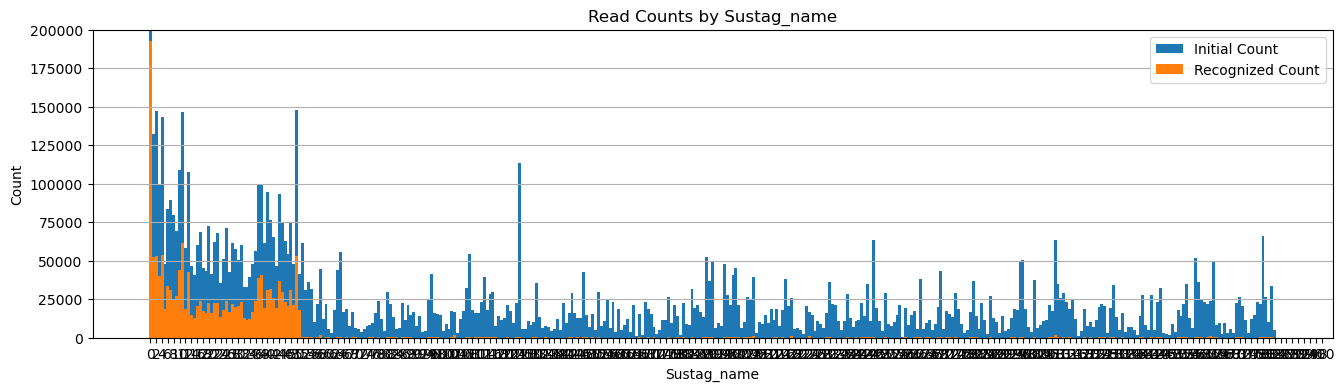

In [30]:
# Extracting data for plotting
x = final_summary['Sustag_name']
initial_count = final_summary['Initial_count']
accepted_count = final_summary['Sustag_target_cnt']

# Plotting the bar chart
plt.figure(figsize=(16, 4))
bar_width = 1
plt.bar(x, initial_count, width=bar_width, label='Initial Count')
plt.bar(x, accepted_count, width=bar_width, label='Recognized Count')


plt.xlabel('Sustag_name')
plt.ylabel('Count')
plt.title('Read Counts by Sustag_name')
plt.xticks(range(0,401,2))
plt.legend()
plt.grid(axis='y')

plt.ylim(0, 2e5)
# plt.xlim(0,60)

plt.show()

In [33]:
recognized_ratio = (final_summary['Sustag_target_cnt'] / final_summary['Initial_count'])*2
# 计算平均值
mean = np.mean(recognized_ratio[1:52])

# 计算标准差
std_dev = np.std(recognized_ratio[1:52])

# 格式化输出为 XX ± XX 的形式
result = f"{mean:.4f} ± {std_dev:.4f}"

print(result)

0.7430 ± 0.0711


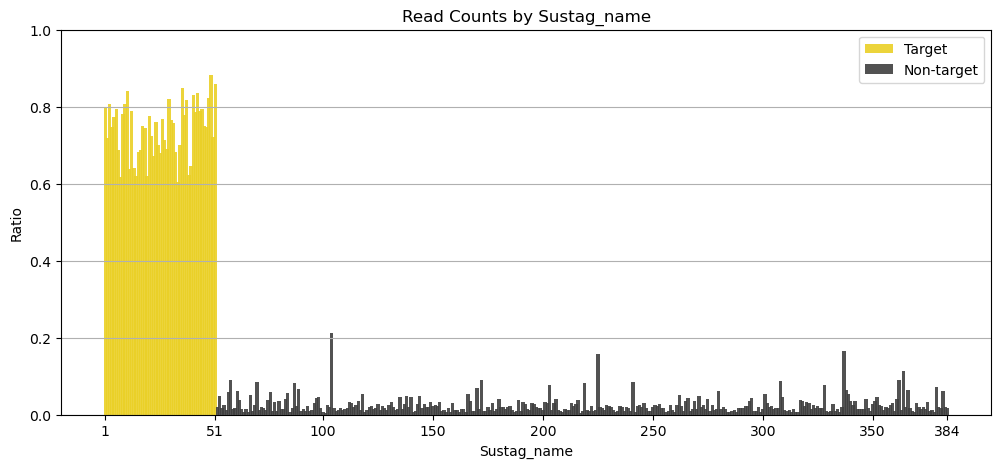

In [31]:
x = final_summary['Sustag_name']
initial_count = final_summary['Initial_count']
recognized_count = final_summary['Sustag_target_cnt']

recognized_ratio = (final_summary['Sustag_target_cnt'] / final_summary['Initial_count'])*2

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 5))
bar_width = 1.5
# ax.bar(x, 1, width=bar_width, label='Initial', color='#afafaf', alpha=0.6)
# ax.bar(x[0], recognized_ratio[0], width=bar_width,color='#7f7f7f', label='Non-target', alpha=0.9)
ax.bar(x[1:52], recognized_ratio[1:52], width=bar_width,color='#ead026', label='Target', alpha=0.9)
ax.bar(x[52:], recognized_ratio[52:], width=bar_width,color='#3f3f3f', label='Non-target', alpha=0.9)

# ax2 = ax.twinx() 
# ax2.scatter(x[1:], initial_count[1:], s=0.3, label='Initial Count')
# ax2.scatter(x[1:], accepted_count[1:], s=0.3, label='Recognized Count') 


ax.set_xlabel('Sustag_name')
ax.set_ylabel('Ratio')
ax.set_title('Read Counts by Sustag_name')
# plt.xticks(range(1,385,20))
ax.set_xticks([1, 51, 100, 150, 200, 250, 300, 350, 384])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend()
plt.grid(axis='y')

# plt.ylim(0, 1.5)
# plt.xlim(0,60)
# plt.savefig('./ORCovL_sustag384_e80_200kft_simru.svg', format='svg')
plt.show()